# Differential correlation analysis

In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from pybedtools import BedTool
import pickle as pkl
%matplotlib inline
import itertools

In [2]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq')
import encode
import memento

In [3]:
pd.set_option('display.max_rows', None)

In [4]:
data_path = '/data_volume/memento/hbec/'
fig_path = '/data/home/Github/scrna-parameter-estimation/figures/fig6/'

In [5]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [6]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)

### Get canonical TFs

In [8]:
tf_df = pd.read_csv('../baseline/human_tf.txt', sep='\t')
tf_list = tf_df['Symbol'].tolist()
tf_list += ['CIITA']

### Read the processed RNA data

Focus on the club and bc/club cells and type I interferons for now.

Encode the timestamps to integers.

In [9]:
# adata_processed = sc.read(data_path + 'HBEC_type_I_processed_deep.h5ad')

In [10]:
adata = sc.read(data_path + 'HBEC_type_I_filtered_counts_deep.h5ad')

In [11]:
adata = adata[:, ~adata.var.index.str.startswith('MT-')].copy()
# adata.obs['cell_type'] = adata.obs['cell_type'].apply(lambda x: x if x != 'basal/club' else 'bc')
# adata.obs['cell_type'] = adata.obs['cell_type'].apply(lambda x: x if x != 'ionocyte/tuft' else 'ion-tuft')

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [12]:
converter = {'basal/club':'BC', 'basal':'B', 'ciliated':'C', 'goblet':'G', 'ionocyte/tuft':'IT', 'neuroendo':'N'}

In [13]:
adata.obs['ct'] = adata.obs['cell_type'].apply(lambda x: converter[x])

### Setup memento

In [14]:
def assign_q(batch):
    
    if batch == 0:
        return 0.387*0.25
    elif batch == 1:
        return 0.392*0.25
    elif batch == 2:
        return 0.436*0.25
    else:
        return 0.417*0.25

In [15]:
adata.obs['q'] = adata.obs['batch'].apply(assign_q)

In [17]:
memento.setup_memento(adata, q_column='q', trim_percent=0.1)

Version 0.0.6


In [20]:
isg_classes = pd.read_csv('../isg_classes.csv')

In [21]:
t1_isg = isg_classes.query('overall_type =="type1"').gene.tolist()
t2_isg = isg_classes.query('overall_type =="type2"').gene.tolist()
shared_isg = isg_classes.query('overall_type == "shared"').gene.tolist()
all_isg = isg_classes[isg_classes.sum(axis=1) > 0]

### Read 1d HT result comparing to control

In [18]:
cts = [['ciliated']]
tps = [ '6',]
stims = ['alpha', 'beta', 'gamma', 'lambda']

In [19]:
def read_result(ct):
    
    ht_dict = {}
    moments_dict = {}
    
    for stim in stims:
        ht_dict[stim] = {}
        moments_dict[stim] = {}
        for tp in tps: 
            adata_subset = sc.read(data_path + '/binary_test_latest/{}_{}_{}.h5ad'.format('-'.join(ct), stim, tp))
            ht_dict[stim][tp] = memento.get_1d_ht_result(adata_subset)
            ht_dict[stim][tp]['de_fdr'] = memento.util._fdrcorrect(ht_dict[stim][tp]['de_pval'])
            ht_dict[stim][tp]['dv_fdr'] = memento.util._fdrcorrect(ht_dict[stim][tp]['dv_pval'])
            moments_dict[stim][tp] = memento.get_1d_moments(adata_subset, groupby='time_step')
    return ht_dict,moments_dict

In [20]:
all_result = {}
for ct in cts:
    
    key = '-'.join(ct)
    all_result[key] = {}
    
    all_result[key]['ht'], all_result[key]['moments'] = read_result(ct)

In [21]:
stims = ['alpha', 'beta', 'gamma', 'lambda']
ct = 'ciliated'
de_genes  = {}
for stim in stims:
    de_genes[stim] = all_result[ct]['ht'][stim]['6'].query('de_fdr < 0.1 & de_coef > 0.5').gene.tolist()
de_genes['alpha/beta'] = set(de_genes['alpha']) | set(de_genes['beta'])

stims = ['gamma', 'lambda', 'alpha/beta']
    
uniq_de_genes = {}
for stim in stims:
    
    uniq_de_genes[stim] = set(de_genes[stim])
    for other in stims:
        if stim == other: continue
        uniq_de_genes[stim] -= set(de_genes[other])
    print(stim, len(uniq_de_genes[stim]))

shared_de_genes = set()
for stim in stims:
    if len(shared_de_genes) == 0:
        shared_de_genes = set(de_genes[stim])
    else:
        shared_de_genes &= set(de_genes[stim])

all_de_genes = set()
for stim in ['alpha', 'beta', 'gamma', 'lambda']:
    all_de_genes |= set(de_genes[stim])
shared_de_genes_lenient = all_de_genes - shared_de_genes
for stim in ['gamma', 'lambda', 'alpha/beta']:
    shared_de_genes_lenient -= uniq_de_genes[stim]

gamma 53
lambda 21
alpha/beta 389


### Run adjusting for STAT1

In [41]:
# First, get correlations without adjustment
stim = 'gamma'
ct = ['C']
adata_stim = adata.copy()[

    adata.obs.ct.isin(ct) & \
    adata.obs.stim.isin([stim])].copy()

adata_stim.obs['group'] = 1
# adata_stim.obs['time_step'] = adata_stim.obs['time']#.astype(int).apply(lambda x: time_converter[x])
# adata_stim.obs['time'] = 'tp_' + adata_stim.obs['time'].astype(str)#.apply(lambda x: time_converter[x])

memento.create_groups(adata_stim, label_columns=['donor', 'group'])
memento.compute_1d_moments(adata_stim, min_perc_group=.9)
# moment_1d_df = memento.get_1d_moments(adata_stim, groupby='is_stim')

available_tfs = list(set(tf_list) & set(adata_stim.var.index))
available_isgs= list(set(t1_isg+t2_isg+shared_isg) & set(adata_stim.var.index))

memento.compute_2d_moments(adata_stim, list(itertools.product(available_tfs, available_isgs)))

moment_df = memento.get_2d_moments(adata_stim, groupby='group')
candidates = moment_df.query('group_1 > 0.35')
memento.compute_2d_moments(adata_stim, list(zip(candidates['gene_1'], candidates['gene_2'])))

# memento.ht_2d_moments( 
#     adata_stim, 
#     formula_like='1 + donor',
#     treatment_col='Inter', 
#     num_boot=10000, 
#     verbose=1,
#     num_cpus=94,
#     resampling='bootstrap',
#     approx=False)

# rho = memento.get_2d_ht_result(adata_stim)

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:614: RuntimeWarning: invalid value encountered in true_divide
  groupby_corr[key] /= groupby_corr_count[key]


In [42]:
# First, get correlations without adjustment
stim = 'gamma'
ct = ['C']
adata_stim = adata.copy()[

    adata.obs.ct.isin(ct) & \
    adata.obs.stim.isin([stim])].copy()

adata_stim.obs['group'] = 1
adata_stim.obs['med_expr'] = adata_stim[:, 'STAT1'].X.todense().A1

memento.create_groups(adata_stim, label_columns=['donor', 'group', 'med_expr'])
memento.compute_1d_moments(adata_stim, min_perc_group=.3)
# moment_1d_df = memento.get_1d_moments(adata_stim, groupby='is_stim')

available_genes = adata_stim.var.index.tolist()

candidates = candidates.query('gene_1 in @available_genes & gene_2 in @available_genes')
print(candidates.shape)


memento.compute_2d_moments(adata_stim, list(zip(candidates['gene_1'], candidates['gene_2'])))

memento.ht_2d_moments( 
    adata_stim, 
    formula_like='1 + donor + med_expr',
    treatment_col='Inter', 
    num_boot=10000, 
    verbose=1,
    num_cpus=94,
    resampling='bootstrap',
    approx=False)

rho_adj = memento.get_2d_ht_result(adata_stim)

(6451, 3)


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 tasks      | elapsed:    5.8s
[Parallel(n_jobs=94)]: Done 262 tasks      | elapsed:   15.5s
[Parallel(n_jobs=94)]: Done 612 tasks      | elapsed:   26.3s
[Parallel(n_jobs=94)]: Done 1062 tasks      | elapsed:   39.6s
[Parallel(n_jobs=94)]: Done 1612 tasks      | elapsed:   54.3s
[Parallel(n_jobs=94)]: Done 2262 tasks      | elapsed:  1.3min
[Parallel(n_jobs=94)]: Done 3012 tasks      | elapsed:  1.7min
[Parallel(n_jobs=94)]: Done 3862 tasks      | elapsed:  2.2min
[Parallel(n_jobs=94)]: Done 4812 tasks      | elapsed:  2.7min
[Parallel(n_jobs=94)]: Done 5862 tasks      | elapsed:  3.3min
[Parallel(n_jobs=94)]: Done 6395 out of 6395 | elapsed:  3.6min finished


In [43]:
delta, se = (rho['corr_coef'] - , np.sqrt(rho['corr_se']**2 + rho_adj['corr_se']**2).valuesrho_adj['corr_coef']).values

In [54]:
merged_rho = rho.merge(rho_adj, on=['gene_1', 'gene_2'], suffixes=('', '_adj'))
merged_rho['diff'] = merged_rho['corr_coef'] - merged_rho['corr_coef_adj']
merged_rho['diff_se'] = np.sqrt(merged_rho['corr_se']**2 + merged_rho['corr_se_adj']**2).values

In [55]:
merged_rho.query('gene_1 == "IRF1"')

,gene_1,gene_2,corr_coef,corr_se,corr_pval,corr_coef_adj,corr_se_adj,corr_pval_adj,diff,diff_se
4079,IRF1,TRIM69,0.465535,0.047907,8.617834e-05,0.361333,0.053707,3.929422e-05,0.104202,0.071969
4080,IRF1,RHBDF2,0.425717,0.046517,6.855414e-05,0.321701,0.052282,1.082546e-04,0.104016,0.069980
4081,IRF1,NLRC5,0.381729,0.039616,4.211939e-05,0.260783,0.049637,5.984877e-05,0.120946,0.063507
4082,IRF1,CX3CL1,0.477023,0.021556,8.094545e-06,0.385392,0.026912,2.464124e-05,0.091631,0.034481
4083,IRF1,TAP1,0.485408,0.024679,8.577731e-07,0.365571,0.031903,8.940797e-06,0.119837,0.040334
4084,IRF1,SMCHD1,0.438747,0.031568,2.164551e-06,0.344486,0.040175,4.189896e-05,0.094261,0.051094
4085,IRF1,PML,0.430521,0.036937,2.207126e-05,0.374509,0.043731,3.889401e-05,0.056012,0.057243
4086,IRF1,UBE2L6,0.369620,0.023327,7.756210e-07,0.182340,0.029804,1.426217e-04,0.187281,0.037848
4087,IRF1,RNF19B,0.379249,0.039797,2.825211e-04,0.302359,0.048612,2.363012e-05,0.076889,0.062824
4088,IRF1,SOCS1,0.459480,0.026219,3.906563e-06,0.446942,0.028009,5.856911e-06,0.012538,0.038366


In [52]:
merged_rho.gene_1.value_counts()

SP100        146
RBCK1        114
ZNFX1        113
SP110        104
PARP12        90
STAT2         82
ETV7          78
CIITA         72
KLF5          72
PLSCR1        68
ZFP36L1       67
BBX           67
FOXN3         65
CSDE1         62
BHLHE40       62
EPAS1         56
TSHZ2         56
IRF1          54
PAX9          54
RFX5          48
SP140L        48
ZNF618        47
AFF1          45
IRF7          44
RREB1         44
JARID2        42
SP1           41
TCF4          41
IRF9          39
TAX1BP1       39
ZNF655        39
CEBPD         37
ZNF207        36
SUB1          35
AFF4          35
TCF7L2        35
ETS2          35
BCL6          34
BATF2         34
KLF3          33
NME2          33
ARID4B        33
NR4A1         32
TOX3          32
HES4          31
PBX1          31
FOSL2         30
MAX           29
ARID1B        29
NFKB2         28
ELK4          28
STAT6         27
THRB          27
ELF3          27
LITAF         27
XBP1          27
CREB3L1       27
ZNF672        26
MAFF          

In [50]:
merged_rho.head(2)

,gene_1,gene_2,corr_coef,corr_se,corr_pval,corr_coef_adj,corr_se_adj,corr_pval_adj
0,FOXC1,ZNFX1,0.391460,0.064695,0.000079,0.304889,0.071393,0.004100
1,FOXC1,PHF11,0.411288,0.087233,0.000489,0.238968,0.096790,0.024798


In [48]:
rho_adj

,gene_1,gene_2,corr_coef,corr_se,corr_pval
0,FOXC1,ZNFX1,0.304889,0.071393,4.099590e-03
1,FOXC1,PHF11,0.238968,0.096790,2.479752e-02
2,FOXC1,PHACTR4,0.395467,0.085323,2.499750e-03
3,NPAS2,FRMD3,0.087488,0.099096,6.650335e-01
4,NPAS2,HERC6,0.167794,0.099480,1.606839e-01
5,NPAS2,SLC18B1,0.201022,0.132192,3.119688e-01
6,NPAS2,N4BP1,0.157528,0.129044,5.074493e-01
7,NPAS2,TAPBP,0.040992,0.099127,6.862314e-01
8,ZNF567,GCA,0.030113,0.111231,8.119188e-01
9,CREM,CARD16,0.163988,0.096618,2.745725e-01


In [44]:
delta

array([ 0.08657027,  0.17231988, -0.01092697, ...,         nan,
               nan,         nan])

In [ ]:
for tf in (set(de_genes['gamma'])&set(tf_list)):
    
    if tf in ['STAT1', 'ATF3'] or tf in adj_results: continue
    
    delta, se = adjust(tf)
    pv = stats.norm.sf(delta, loc=0, scale=se)
    adj_results[tf] = (delta, se, pv)

In [79]:
def adjust(mediator):
        
    adata_stim = adata.copy()[

        adata.obs.cell_type.isin(ct) & \
        adata.obs.stim.isin([stim])].copy()
    
    adata_stim.obs['time_step'] = adata_stim.obs['time']#.astype(int).apply(lambda x: time_converter[x])
    adata_stim.obs['time'] = 'tp_' + adata_stim.obs['time'].astype(str)#.apply(lambda x: time_converter[x])

    adata_stim.obs['med_expr'] = adata_stim[:, mediator].X.todense().A1
    memento.create_groups(adata_stim, label_columns=['donor', 'med_expr'])
    memento.compute_1d_moments(adata_stim, min_perc_group=.5)
    # moment_1d_df = memento.get_1d_moments(adata_stim, groupby='is_stim')

    memento.compute_2d_moments(adata_stim, list(itertools.product(['STAT1'], c2_genes)))

    # moment_df = memento.get_2d_moments(adata_stim, groupby='is_stim')

    memento.ht_2d_moments( 
        adata_stim, 
        formula_like='1 + donor + med_expr',
        treatment_col='Inter', 
        num_boot=10000, 
        verbose=0,
        num_cpus=94,
        resampling='permutation',
        approx=False)

    rho_adj = memento.get_2d_ht_result(adata_stim)
    
    return (rho['corr_coef'] - rho_adj['corr_coef']).values, np.sqrt(rho['corr_se']**2 + rho_adj['corr_se']**2).values

In [80]:
delta, se = adjust('CIITA')
print(stats.norm.sf(delta, loc=0, scale=se))

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


[0.02957654 0.07684802 0.0303681  0.18115575 0.12129824 0.11322488
 0.14126288]


In [86]:
for tf in (set(de_genes['gamma'])&set(tf_list)):
    
    if tf in ['STAT1', 'ATF3'] or tf in adj_results: continue
    
    delta, se = adjust(tf)
    pv = stats.norm.sf(delta, loc=0, scale=se)
    adj_results[tf] = (delta, se, pv)

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in

In [90]:
result_df = []
for tf, val in adj_results.items():
    
    a = pd.DataFrame()
    a['gene'] = c2_genes
    a['se'] = val[1]
    a['delta_rho'] = val[0]
    a['pv'] = val[2]
    a['tf'] = tf
    result_df.append(a)
result_df = pd.concat(result_df)

<AxesSubplot:xlabel='delta_rho', ylabel='tf'>

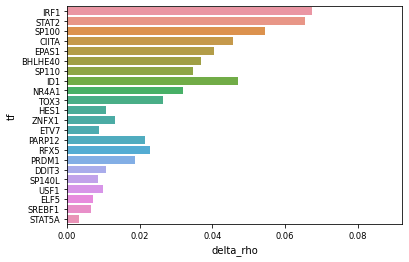

In [101]:
sns.barplot(y='tf', x='delta_rho', data=result_df.sort_values('delta_rho', ascending=False), errwidth=0)

Text(0.5, 0, '$\\Delta\\rho_{\\mathrm{ADJ}} - \\Delta\\rho$')

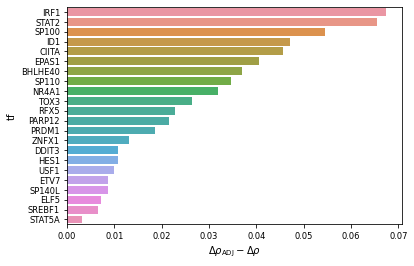

In [119]:
sns.barplot(y='tf', x='delta_rho', data=result_df.groupby('tf')['delta_rho'].mean().sort_values(ascending=False).reset_index(name='delta_rho'))
plt.xlabel(r'$\Delta\rho_{\mathrm{ADJ}} - \Delta\rho$')

In [120]:
pv = result_df.groupby('tf')['pv'].apply(lambda x: stats.combine_pvalues(x)[1]).sort_values()

In [123]:
fdr = memento.util._fdrcorrect(pv)

In [124]:
fdr

array([7.55244762e-05, 7.55244762e-05, 1.10957744e-03, 6.23741967e-03,
       6.23741967e-03, 1.32869976e-02, 2.27980676e-02, 4.69593632e-02,
       4.90070567e-02, 1.49024080e-01, 2.22171945e-01, 2.84743085e-01,
       3.56540155e-01, 5.81178396e-01, 5.81178396e-01, 5.81178396e-01,
       5.81178396e-01, 5.81178396e-01, 5.88793778e-01, 6.23966965e-01,
       6.29748894e-01, 6.87918333e-01])

In [63]:
delta, se = adjust('JUNB')
print(stats.norm.sf(delta, loc=0, scale=se))

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done   4 out of   7 | elapsed:    2.7s remaining:    2.0s
[Parallel(n_jobs=94)]: Done   7 out of   7 | elapsed:    3.8s finished
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done   4 out of   7 | elapsed:   10.0s remaining:    7.5s


[0.16144843 0.21353627 0.20754591 0.15573289 0.34621325 0.30872167
 0.52620379]


[Parallel(n_jobs=94)]: Done   7 out of   7 | elapsed:   14.5s finished


In [62]:
delta, se = adjust('CIITA')
print(stats.norm.sf(delta, loc=0, scale=se))

array([0.03102337, 0.07709145, 0.03047889, 0.1810527 , 0.11786292,
       0.10992212, 0.13843179])

### Run differential correlation between STAT1 and each stim's DEGs

In [22]:
ct = ['ciliated']
all_stims = ['gamma', 'lambda', 'alpha', 'beta']

In [91]:
for stim in all_stims:
    
    print('starting ', stim, '....')

    adata_stim = adata.copy()[
        adata.obs.cell_type.isin(ct) & \
        adata.obs.stim.isin(['control', stim])].copy()
    
    # time_converter={0:0, int('6'):1}
    adata_stim.obs['time_step'] = adata_stim.obs['time']#.astype(int).apply(lambda x: time_converter[x])
    adata_stim.obs['time'] = 'tp_' + adata_stim.obs['time'].astype(str)

    memento.create_groups(adata_stim, label_columns=['time', 'donor'])
    memento.compute_1d_moments(adata_stim, min_perc_group=.3)
    moment_1d_df = memento.get_1d_moments(adata_stim, groupby='time')

#     available_tfs = list(set(tf_list) & set(moment_1d_df[0].gene))
    available_targets = list(set(de_genes[stim if stim not in ['alpha', 'beta'] else 'alpha/beta']) & set(moment_1d_df[0].gene))

    memento.compute_2d_moments(adata_stim, list(itertools.product(['STAT1'], available_targets)))

#     moment_df = memento.get_2d_moments(adata_stim, groupby='time') 

#     moment_df['max_corr'] = moment_df.iloc[:, 2:].max(axis=1).values

#     candidates = moment_df.query('max_corr > 0.3 & gene_1 != gene_2')

# #     top_tfs = candidates.groupby('gene_1').size().sort_values(ascending=False)
# #     top_tfs = top_tfs[top_tfs > 15].index.tolist()

# #     candidates = candidates.query('gene_1 in @top_tfs')

#     candidates = list(zip(candidates['gene_1'], candidates['gene_2']))

#     memento.compute_2d_moments(adata_stim, candidates)

    memento.ht_2d_moments( 
        adata_stim, 
        formula_like='1 + time + donor',
        treatment_col='time', 
        num_boot=10000, 
        verbose=1,
        num_cpus=94,
        resampling='permutation',
        approx=False)
    
    adata_stim.write(data_path + 'stat1_coex_test/{}.h5ad'.format(stim))


starting  gamma ....


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/estimator.py:105: RuntimeWarning: invalid value encountered in log
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:523: RuntimeWarning: divide by zero encountered in log
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:550: RuntimeWarning: divide by zero encountered in log
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:562: RuntimeWarning: invalid value encountered in true_divide
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 t

starting  lambda ....


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/estimator.py:105: RuntimeWarning: invalid value encountered in log
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:523: RuntimeWarning: divide by zero encountered in log
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:550: RuntimeWarning: divide by zero encountered in log
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:562: RuntimeWarning: invalid value encountered in true_divide
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done 198 o

starting  alpha ....


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/estimator.py:105: RuntimeWarning: invalid value encountered in log
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:523: RuntimeWarning: divide by zero encountered in log
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:550: RuntimeWarning: divide by zero encountered in log
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:562: RuntimeWarning: invalid value encountered in true_divide
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 t

starting  beta ....


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/estimator.py:105: RuntimeWarning: invalid value encountered in log
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:523: RuntimeWarning: divide by zero encountered in log
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:550: RuntimeWarning: divide by zero encountered in log
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:562: RuntimeWarning: invalid value encountered in true_divide
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 t

In [ ]:
for stim in all_stims:
        
    print('starting ', stim, '....')

    adata_stim = adata.copy()[
        adata.obs.cell_type.isin(ct) & \
        adata.obs.stim.isin(['control', stim])].copy()
    
    time_converter={'0':0, '3':1, '6':2, '9':3, '24':4, '48':5}
    adata_stim.obs['time_step'] = adata_stim.obs['time']#.astype(int).apply(lambda x: time_converter[x])
    adata_stim.obs['time'] = 'tp_' + adata_stim.obs['time'].astype(str)#.apply(lambda x: time_converter[x])
    adata_stim.obs['is_stim'] = (adata_stim.obs.stim==stim).astype(int)

    memento.create_groups(adata_stim, label_columns=['is_stim','time', 'donor'])
    memento.compute_1d_moments(adata_stim, min_perc_group=.3)
    moment_1d_df = memento.get_1d_moments(adata_stim, groupby='time')

    available_targets = list(set(de_genes[stim]) & set(moment_1d_df[0].gene))

    memento.compute_2d_moments(adata_stim, list(itertools.product(['STAT1'], available_targets)))

    moment_df = memento.get_2d_moments(adata_stim, groupby='time') 

#     moment_df['max_corr'] = moment_df.iloc[:, 2:].max(axis=1).values

#     candidates = moment_df.query('max_corr > 0.3 & gene_1 != gene_2')

#     candidates = list(zip(candidates['gene_1'], candidates['gene_2']))

#     memento.compute_2d_moments(adata_stim, candidates)
    
    memento.ht_2d_moments( 
        adata_stim, 
        formula_like='1 + is_stim + donor',
        treatment_col='is_stim', 
        num_boot=10000, 
        verbose=1,
        num_cpus=94,
        resampling='permutation',
        approx=False)
    
    adata_stim.write(data_path + 'stat1_coex_test/{}_linear.h5ad'.format(stim))


starting  gamma ....


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/estimator.py:105: RuntimeWarning: invalid value encountered in log
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:523: RuntimeWarning: divide by zero encountered in log
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:550: RuntimeWarning: divide by zero encountered in log
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:562: RuntimeWarning: invalid value encountered in true_divide
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 t

starting  lambda ....


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/estimator.py:105: RuntimeWarning: invalid value encountered in log
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:523: RuntimeWarning: divide by zero encountered in log
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:550: RuntimeWarning: divide by zero encountered in log
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:562: RuntimeWarning: invalid value encountered in true_divide
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:614: RuntimeWarn

### Read DC results

In [80]:
def classify(x):
    
    if x in shared_de_genes:
        return 'shared'
    elif x in shared_de_genes_lenient:
        return 'partially_shared'
    for stim in stims:
        if x in uniq_de_genes[stim]:
            return 'uniq_' + stim
    return 'none-DE'

In [145]:
deg_dc_results = {}
deg_2d_moments = {}
deg_m_moments = {}
deg_v_moments = {}
combined_results = {}

for stim in all_stims:
    
    adata_stim = sc.read(data_path + 'stat1_coex_test/{}_linear.h5ad'.format(stim))
    deg_dc_results[stim] = memento.get_2d_ht_result(adata_stim)
    deg_2d_moments[stim] = memento.get_2d_moments(adata_stim, groupby='time')[['gene_1','gene_2'] + ['time_'+str(i) for i in [0, 1, 2, 3, 4, 5]]]
#     deg_m_moments[stim],deg_v_moments[stim] = memento.get_1d_moments(adata_stim, groupby='time')
#     deg_m_moments[stim] = deg_m_moments[stim][['gene'] + ['time_'+str(i) for i in [0, 3, 6, 9, 24, 48]]]
#     deg_v_moments[stim] = deg_v_moments[stim][['gene'] + ['time_'+str(i) for i in [0, 3, 6, 9, 24, 48]]]
    deg_dc_results[stim]['corr_fdr'] = memento.util._fdrcorrect(deg_dc_results[stim]['corr_pval'])
    
    combined_results[stim] = deg_2d_moments[stim].merge(deg_dc_results[stim], on=['gene_1', 'gene_2'])
    combined_results[stim]['deg_type'] = combined_results[stim]['gene_2'].apply(classify)
    combined_results[stim]['sig'] =  (combined_results[stim]['corr_fdr'] < 0.05) & (combined_results[stim]['corr_coef'] > 0.0)
    
   

### Differential correlation and sharedness

In [146]:
a = deg_dc_results['lambda']

In [147]:
a['is_uniq'] = a['gene_2'].isin(uniq_de_genes['lambda'])

In [150]:
combined_results['lambda'].sort_values('corr_coef', ascending=False)

,gene_1,gene_2,time_0,time_1,time_2,time_3,time_4,time_5,corr_coef,corr_se,corr_pval,corr_fdr,deg_type,sig
152,STAT1,GSTA4,-0.114069,0.216478,0.216478,0.217556,0.221651,0.235981,0.103536,0.022920,0.000222,0.011313,uniq_lambda,True
9,STAT1,ZYX,-0.072388,0.078469,0.078469,0.073202,0.045811,0.127582,0.100967,0.032542,0.003100,0.013949,uniq_lambda,True
52,STAT1,CTDSP1,-0.265068,0.128000,0.128000,0.152787,0.106809,0.178078,0.091377,0.037092,0.013799,0.044789,partially_shared,True
189,STAT1,CHPT1,-0.139704,0.128094,0.128094,0.139944,0.177663,0.148499,0.089075,0.023753,0.000686,0.011313,uniq_lambda,True
153,STAT1,MYC,-0.130424,0.099678,0.099678,0.089579,0.108588,0.131956,0.088699,0.022932,0.000636,0.011313,uniq_lambda,True
94,STAT1,F3,-0.074340,0.115347,0.115347,0.154803,0.093805,0.168025,0.086685,0.012815,0.000340,0.011313,shared,True
76,STAT1,ATP6V1C2,-0.080710,0.131857,0.131857,0.132558,0.147808,0.145928,0.084827,0.030022,0.006499,0.024748,shared,True
74,STAT1,SLC16A9,-0.022098,0.178907,0.178907,0.235420,0.124071,0.243805,0.083314,0.024766,0.001700,0.011436,partially_shared,True
55,STAT1,TOR1B,0.111860,0.352982,0.352982,0.381142,0.370164,0.373865,0.082824,0.034430,0.015898,0.050772,partially_shared,False
7,STAT1,VEGFA,-0.018837,0.129133,0.129133,0.143994,0.109418,0.147115,0.080101,0.018003,0.000309,0.011313,shared,True


In [138]:
deg_dc_results['lambda']#.query('deg_type=="shared"')

,gene_1,gene_2,corr_coef,corr_se,corr_pval,corr_fdr,deg_type,sig,is_uniq
0,STAT1,FUT2,0.027354,0.026838,0.301670,0.455959,shared,False,False
1,STAT1,SP100,-0.025332,0.019409,0.191181,0.337980,shared,False,False
2,STAT1,U62317.4,-0.023812,0.019326,0.216178,0.365840,shared,False,False
3,STAT1,NIBAN1,0.055524,0.019968,0.005799,0.022966,partially_shared,True,False
4,STAT1,PARP14,0.037395,0.012909,0.003700,0.015924,shared,True,False
5,STAT1,VWA1,0.059357,0.033733,0.077392,0.178182,partially_shared,False,False
6,STAT1,DDIT4,0.022083,0.012699,0.082092,0.186830,partially_shared,False,False
7,STAT1,VEGFA,0.080101,0.018003,0.000309,0.011313,shared,True,False
8,STAT1,PIM3,0.041044,0.018885,0.028397,0.081488,shared,True,False
9,STAT1,ZYX,0.100967,0.032542,0.003100,0.013949,uniq_lambda,True,True


In [120]:
for stim in all_stims:
    
    contingency = pd.crosstab(
        deg_dc_results[stim]['deg_type']=='shared', 
        deg_dc_results[stim]['sig'])
    print(stim)
    print(contingency)
    print(stim, stats.fisher_exact(contingency))

gamma
sig       False  True 
deg_type              
False        80    128
True         54     58
gamma (0.6712962962962963, 0.09758328740019982)
lambda
sig       False  True 
deg_type              
False        53     34
True         75     37
lambda (0.7690196078431373, 0.4559317190052937)
alpha
sig       False  True 
deg_type              
False       223    220
True         34     67
alpha (1.9974598930481284, 0.002785560119163853)
beta
sig       False  True 
deg_type              
False       247    281
True         23     89
beta (3.40136159678168, 1.7453076407822353e-07)


In [82]:
ht_2d_df = memento.get_2d_ht_result(adata_stim)
ht_2d_df['corr_fdr'] = memento.util._fdrcorrect(ht_2d_df['corr_pval'])
sig_df = ht_2d_df.query('corr_fdr < 0.1')

In [83]:
tp_order = ['time_tp_' + str(i) for i in [0, 3, 6, 9, 24, 48]]

In [90]:
moment_1d_df[0].query('gene == "CIITA"')[tp_order]

,time_tp_0,time_tp_3,time_tp_6,time_tp_9,time_tp_24,time_tp_48
8497,-2.216917,-0.133482,-0.250962,-0.205729,-0.256063,-0.471048


In [85]:
dra=moment_df.merge(sig_df[['gene_1', 'gene_2']], on=['gene_1', 'gene_2'], how='inner')\
    .query('gene_2.str.startswith("HLA-DRA")', engine='python')[['gene_1', 'gene_2'] + tp_order]

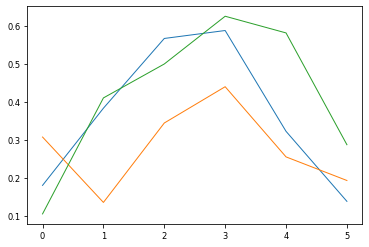

In [86]:
plt.plot(dra[tp_order].values.T, lw=1);